<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="../src/copernicus-logo.png"><span style="margin-left: 40px"></span><img src="../src/cds-logo.jpeg">

# Data Modelling

During this phase, we will discuss about possibles models to predict discharge given a temperature and past history of a particular river location according to the result of the Granger Causality.

## Choice of the Model

According to the Data Analysis assumption, we will define some prediction models related to the correlation with temperatures and precipitations where these variables have causal dependant on the river location of our interest. In other words, we can predict the future discharge values of a given point using different approaches based on the impact of temperatures and precipitation variations on the river flow. In this notebook, we will analyze different algorithms and choose the best one for both approaches specified at the end of the data analysis notebook. In detail, we can test the prediction efficiency using RMSE evaluation on the testing set (composed of samples on the 2021-2022 periods). During the application usage, models will be trained on the complete dataset to improve the future prediction of the period above 2022.


## Libraries dependencies

In [169]:
%pip install seaborn
%pip instal matplotlib
%pip install sklearn
%pip install pandas
%pip install pmdarima
%pip install keras
%pip install tensorflow
#!pip install seaborn

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "instal" - maybe you meant "install"
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need t

In [1]:
import datetime, json
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.dates as mdates
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from  statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore') 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [10]:
j = 6
df = pd.DataFrame(columns=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])
for i in range(2011, 2023):
    tmp = pd.read_csv("../samples/italy-dtp-{}-{}.csv".format(i,j), usecols=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])
    df = pd.concat([df, tmp])
    j += 1

In [11]:
# print the head of dataset.
data = df
df.head()

,time,lat,lon,discharge,temp,prec
0,2011-01-01 12:00:00,44.750378,7.56052,11.211914,5.205774,0.0
1,2011-01-02 12:00:00,44.750378,7.56052,10.950195,4.364069,0.000006
2,2011-01-03 12:00:00,44.750378,7.56052,10.685547,6.473016,0.000002
3,2011-01-04 12:00:00,44.750378,7.56052,10.419922,8.097437,0.0
4,2011-01-05 12:00:00,44.750378,7.56052,10.15918,6.304498,0.0


In [12]:
df.describe()

,time,lat,lon,discharge,temp,prec
count,36972957,3.697296e+07,3.697296e+07,3.697296e+07,3.697296e+07,36972957.0
unique,4151,8.899000e+03,8.905000e+03,9.506530e+05,1.628880e+06,30549027.0
top,2011-01-01 12:00:00,4.666971e+01,9.002067e+00,9.765625e-04,1.226299e+01,0.0
freq,8907,8.302000e+03,8.302000e+03,6.844300e+04,7.800000e+01,4337737.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36972957 entries, 0 to 1184630
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   time       object
 1   lat        object
 2   lon        object
 3   discharge  object
 4   temp       object
 5   prec       object
dtypes: object(6)
memory usage: 1.9+ GB


## Preprocessing Data

This phase is in common with the Data Analytics due to the dataframe preparation using the stored data.

In [14]:
# defines coordinates of filtering and group by their locations.
df_coordinates = df[df['discharge'] != 0]
df_coordinates = df.groupby(by=["lat", "lon"], as_index=False, squeeze=True)
aggregation_functions = {'discharge': 'mean', 'temp': 'mean', 'time': 'first', 'prec' : 'mean'}
df_coordinates = df_coordinates.aggregate(aggregation_functions)

In [15]:
# set the coordinates as index of the dataframe
df_drop = df.drop(columns = ['time', 'discharge', 'temp', 'prec'], inplace=False)
df['coords'] = df_drop.apply(tuple, axis=1)
df = df.set_index(['coords', 'time'])
df.tail()

lat        lon discharge  \
coords                time                                                 
(41.23425, 13.701608) 2022-05-09 12:00:00  41.23425  13.701608  0.193359   
                      2022-05-10 12:00:00  41.23425  13.701608  0.158203   
                      2022-05-11 12:00:00  41.23425  13.701608  0.144043   
                      2022-05-12 12:00:00  41.23425  13.701608  0.137695   
                      2022-05-13 12:00:00  41.23425  13.701608  0.133789   

                                                temp      prec  
coords                time                                      
(41.23425, 13.701608) 2022-05-09 12:00:00   16.09704  0.000024  
                      2022-05-10 12:00:00   16.31582  0.000002  
                      2022-05-11 12:00:00  18.108545       0.0  
                      2022-05-12 12:00:00    18.9703       0.0  
                      2022-05-13 12:00:00  19.163446       0.0

In [16]:
# filter points from original dataset to geojson coordinates related to river positions.
coords = json.load(open('../app/static/data/points_new_fill.geojson', 'r'))
lats = []
longs = []
for coord in coords['features'][:]:
    sample = coord['geometry']['coordinates']
    lats.append(sample[1])
    longs.append(sample[0])

print(coords['features'][:2])


[{'type': 'Feature', 'name': 'Fiume Po', 'id': 0, 'geometry': {'type': 'Point', 'coordinates': [7.6197023, 44.841927]}}, {'type': 'Feature', 'name': 'Po', 'id': 1, 'geometry': {'type': 'Point', 'coordinates': [7.673447, 45.068577]}}]


In [17]:
coords_tuple = []
for i in range(len(lats)):
    coords_tuple.append(tuple([lats[i], longs[i]]))

rivers = pd.DataFrame()
rivers = data[data['coords'].isin(coords_tuple)]
rivers.head()

,time,lat,lon,discharge,temp,prec,coords
18980,2011-01-01 12:00:00,44.841927,7.619702,58.29492,5.29165,0.0,"(44.841927, 7.6197023)"
18981,2011-01-02 12:00:00,44.841927,7.619702,56.325195,4.353876,0.000002,"(44.841927, 7.6197023)"
18982,2011-01-03 12:00:00,44.841927,7.619702,54.467773,5.771906,0.000001,"(44.841927, 7.6197023)"
18983,2011-01-04 12:00:00,44.841927,7.619702,52.753906,8.080682,0.0,"(44.841927, 7.6197023)"
18984,2011-01-05 12:00:00,44.841927,7.619702,51.195312,6.497247,0.0,"(44.841927, 7.6197023)"


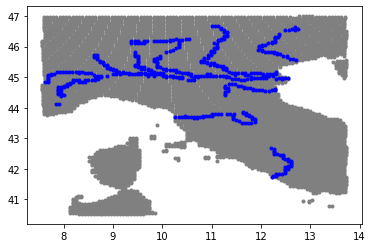

In [18]:
coords_rivers = rivers.groupby(by=["lat", "lon"], as_index=False, squeeze=True)
aggregation_functions = {'discharge': 'mean', 'temp': 'mean', 'time': 'first', 'prec' : 'mean'}
coords_rivers = coords_rivers.aggregate(aggregation_functions)
plt.plot(df_coordinates['lon'], df_coordinates['lat'], '.', color='gray')
plt.plot(coords_rivers['lon'], coords_rivers['lat'], '.', color='blue')

In [22]:
datasource = json.load(open('../samples/source_mouth.json', 'r'))
sources_rivers = []
names = []
mounths_rivers = []
italy_sources_mounths = pd.DataFrame()
for key in datasource.keys():
    sources_rivers.append(datasource[key]['source'])
    mounths_rivers.append(datasource[key]['mounth'])
    names.append(key)

italy_sources_mounths['names'] = names
italy_sources_mounths['mounth'] = mounths_rivers
italy_sources_mounths['source'] = sources_rivers
italy_sources_mounths['number_value'] = [i for i in range(0, len(italy_sources_mounths))]
italy_sources_mounths.head()

,names,mounth,source,number_value
0,Tanaro,"[44.950962, 8.690675]","[44.12503, 7.8367176]",0
1,Po,"[44.974716, 12.487255]","[44.841927, 7.6197023]",1
2,Tevere,"[41.730213, 12.233403]","[42.679653, 12.207837]",2
3,Arno,"[43.69623, 10.266045]","[43.864105, 11.632074]",3
4,Reno,"[44.61863, 12.282794]","[44.410408, 11.271765]",4


In [23]:
sources = {}
mounths = {}
names = list(italy_sources_mounths.names)
print("Time series on the following rivers: {}".format(names))
for i in range(len(italy_sources_mounths)):
    name = names[i]
    sources[name] = rivers[rivers['coords'] == tuple(italy_sources_mounths['source'][i])]
    mounths[name] = rivers[rivers['coords'] == tuple(italy_sources_mounths['mounth'][i])]

Time series on the following rivers: ['Tanaro', 'Po', 'Tevere ', 'Arno', 'Reno', 'Ticino', 'Adda', 'Oglio', 'Adige', 'Piave']


In [24]:
sources['Po'].head()

,time,lat,lon,discharge,temp,prec,coords
18980,2011-01-01 12:00:00,44.841927,7.619702,58.29492,5.29165,0.0,"(44.841927, 7.6197023)"
18981,2011-01-02 12:00:00,44.841927,7.619702,56.325195,4.353876,0.000002,"(44.841927, 7.6197023)"
18982,2011-01-03 12:00:00,44.841927,7.619702,54.467773,5.771906,0.000001,"(44.841927, 7.6197023)"
18983,2011-01-04 12:00:00,44.841927,7.619702,52.753906,8.080682,0.0,"(44.841927, 7.6197023)"
18984,2011-01-05 12:00:00,44.841927,7.619702,51.195312,6.497247,0.0,"(44.841927, 7.6197023)"


In [26]:
sources2 = {}
mounths2 = {}
for name in names:
    df = sources[name].copy(deep=True)
    df2 = mounths[name].copy(deep=True)
    df.index = sources[name]['time']
    df2.index = mounths[name]['time']
    df.drop(columns=['time'], inplace=True)
    df2.drop(columns=['time'], inplace=True)
    sources2[name] = df.copy(deep=True)
    mounths2[name] = df2.copy(deep=True)
print(sources['Po'].head())
print('-'*40)
print(mounths['Po'].head())


                      time        lat       lon  discharge      temp  \
18980  2011-01-01 12:00:00  44.841927  7.619702   58.29492   5.29165   
18981  2011-01-02 12:00:00  44.841927  7.619702  56.325195  4.353876   
18982  2011-01-03 12:00:00  44.841927  7.619702  54.467773  5.771906   
18983  2011-01-04 12:00:00  44.841927  7.619702  52.753906  8.080682   
18984  2011-01-05 12:00:00  44.841927  7.619702  51.195312  6.497247   

           prec                  coords  
18980       0.0  (44.841927, 7.6197023)  
18981  0.000002  (44.841927, 7.6197023)  
18982  0.000001  (44.841927, 7.6197023)  
18983       0.0  (44.841927, 7.6197023)  
18984       0.0  (44.841927, 7.6197023)  
----------------------------------------
                        time        lat        lon  discharge      temp  \
2570330  2011-01-01 12:00:00  44.974716  12.487255  1926.4092  7.344354   
2570331  2011-01-02 12:00:00  44.974716  12.487255  1750.8271   7.95199   
2570332  2011-01-03 12:00:00  44.974716  12.48725

## Starting Modelling Phase

Text(0, 0.5, 'Discharge (m^3/s)')

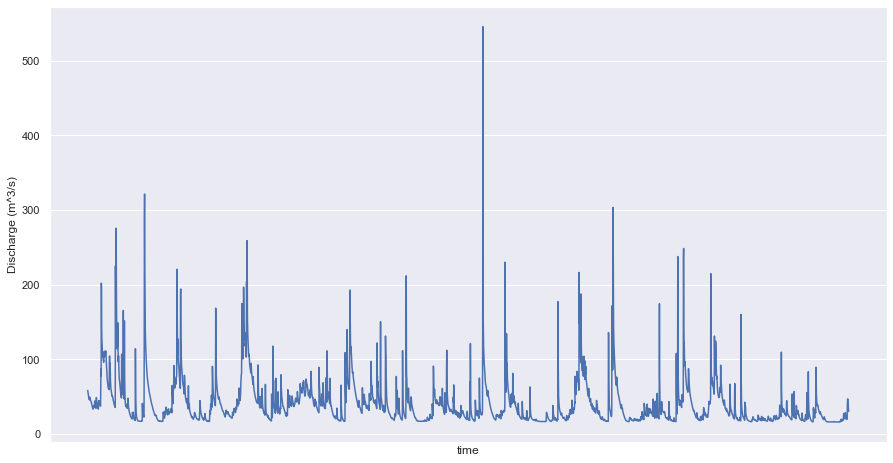

In [27]:
sns.set(rc={'figure.figsize':(15, 8)})
ax = sns.lineplot(x='time', y='discharge', data=sources2['Po'], markers='')
ax.set_xticks([])
ax.set_ylabel('Discharge (m^3/s)')

Text(0, 0.5, 'Discharge (m^3/s)')

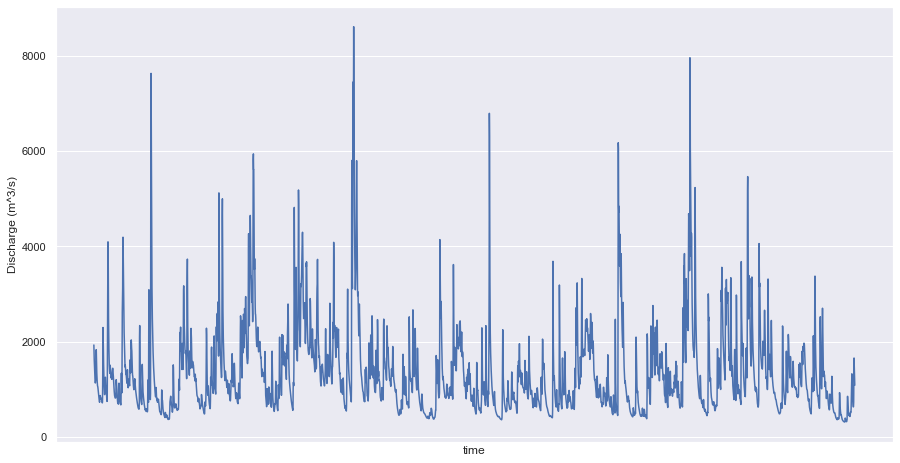

In [28]:

sns.set(rc={'figure.figsize':(15, 8)})
ax = sns.lineplot(x='time', y='discharge', data=mounths2['Po'], markers='')
ax.set_xticks([])
ax.set_ylabel('Discharge (m^3/s)')

According to the analysis observations, the month of discharge is exponentially more significant than the values of the source. So, we need to verify if the prediction on sources which low variability has the similar performances to the month forecasting

### Data Splitting

In [256]:
sources['Po'].head()

,time,lat,lon,discharge,temp,prec,coords
18980,2011-01-01 12:00:00,44.841927,7.619702,58.29492,5.29165,0.0,"(44.841927, 7.6197023)"
18981,2011-01-02 12:00:00,44.841927,7.619702,56.325195,4.353876,0.000002,"(44.841927, 7.6197023)"
18982,2011-01-03 12:00:00,44.841927,7.619702,54.467773,5.771906,0.000001,"(44.841927, 7.6197023)"
18983,2011-01-04 12:00:00,44.841927,7.619702,52.753906,8.080682,0.0,"(44.841927, 7.6197023)"
18984,2011-01-05 12:00:00,44.841927,7.619702,51.195312,6.497247,0.0,"(44.841927, 7.6197023)"


In [257]:
train = {}
test = {}
keys = sources.keys()
for key in keys:
    # 90% Training set and 10% Testing Set
    train[key] = {'source' : pd.DataFrame(), 'mounth' : pd.DataFrame()}
    test[key] = {'source' : pd.DataFrame(), 'mounth' : pd.DataFrame()}
    train[key]['source'] = sources[key][:int(0.7*(len(sources[key])))]
    test[key]['source'] =  sources[key][int(0.7*(len(sources[key]))):]
    train[key]['mounth'] = mounths[key][:int(0.7*(len(mounths[key])))]
    test[key]['mounth'] = mounths[key][int(0.7*(len(mounths[key]))):]


In [258]:
train['Po']['source'].tail()

,time,lat,lon,discharge,temp,prec,coords
19323,2018-12-10 12:00:00,44.841927,7.619702,45.185547,3.303064,0.0,"(44.841927, 7.6197023)"
19324,2018-12-11 12:00:00,44.841927,7.619702,43.887695,3.920343,0.0,"(44.841927, 7.6197023)"
19325,2018-12-12 12:00:00,44.841927,7.619702,42.578125,3.687463,0.0,"(44.841927, 7.6197023)"
19326,2018-12-13 12:00:00,44.841927,7.619702,41.271484,4.609155,0.0,"(44.841927, 7.6197023)"
19327,2018-12-14 12:00:00,44.841927,7.619702,40.001953,4.014276,0.0,"(44.841927, 7.6197023)"


In [259]:
test['Po']['source'].head()

,time,lat,lon,discharge,temp,prec,coords
19328,2018-12-15 12:00:00,44.841927,7.619702,38.770508,8.275415,0.0,"(44.841927, 7.6197023)"
19329,2018-12-16 12:00:00,44.841927,7.619702,37.621094,8.326166,0.0,"(44.841927, 7.6197023)"
19330,2018-12-17 12:00:00,44.841927,7.619702,36.5166,7.226068,0.0,"(44.841927, 7.6197023)"
19331,2018-12-18 12:00:00,44.841927,7.619702,35.50879,6.319177,0.000001,"(44.841927, 7.6197023)"
19332,2018-12-19 12:00:00,44.841927,7.619702,34.407227,6.64361,0.0,"(44.841927, 7.6197023)"


In [260]:
for key in keys:
    train[key]['source'] = train[key]['source'].drop(columns=['lat', 'lon', 'coords'])
    train[key]['mounth'] = train[key]['mounth'].drop(columns=['lat', 'lon', 'coords'])
    test[key]['source'] = test[key]['source'].drop(columns=['lat', 'lon', 'coords'])
    test[key]['mounth'] = test[key]['mounth'].drop(columns=['lat', 'lon', 'coords'])

In [261]:
train['Po']['source'].head()

,time,discharge,temp,prec
18980,2011-01-01 12:00:00,58.29492,5.29165,0.0
18981,2011-01-02 12:00:00,56.325195,4.353876,0.000002
18982,2011-01-03 12:00:00,54.467773,5.771906,0.000001
18983,2011-01-04 12:00:00,52.753906,8.080682,0.0
18984,2011-01-05 12:00:00,51.195312,6.497247,0.0


## ARIMA Modelling

In [262]:
# prepare a copy of data for SARIMA 
arima_train = {}
arima_test = {}

for key in keys:
    # define key
    arima_train[key] = {'source' : pd.DataFrame(), 'mounth' : pd.DataFrame()}
    arima_test[key] = {'source' : pd.DataFrame(), 'mounth' : pd.DataFrame()}
    # copy from the original dataset
    for x in ['source', 'mounth']:
        arima_train[key][x] = train[key][x].copy(deep=True)
        arima_test[key][x] = test[key][x].copy(deep=True)
        # setup info in the correct format type)
        arima_train[key][x]['discharge'] = arima_train[key][x]['discharge'].astype(float)
        arima_train[key][x]['time'] = pd.to_datetime(arima_train[key][x]['time'], format = '%Y-%m-%d %H:%M:%S')
        arima_train[key][x].index = arima_train[key][x]['time']
        arima_test[key][x]['discharge'] = arima_test[key][x]['discharge'].astype(float)
        arima_test[key][x]['time'] = pd.to_datetime(arima_test[key][x]['time'], format = '%Y-%m-%d %H:%M:%S')
        arima_test[key][x].index = arima_test[key][x]['time']




# verify results
arima_train['Po']['mounth'].head()
    

,time,discharge,temp,prec
time,,,,
2011-01-01 12:00:00,2011-01-01 12:00:00,1926.4092,7.344354,0.000054
2011-01-02 12:00:00,2011-01-02 12:00:00,1750.8271,7.95199,0.000243
2011-01-03 12:00:00,2011-01-03 12:00:00,1616.0498,7.214838,0.000044
2011-01-04 12:00:00,2011-01-04 12:00:00,1508.9209,8.700403,0.000007
2011-01-05 12:00:00,2011-01-05 12:00:00,1415.3057,5.722192,0.0


In [263]:
locs = ['source', 'mounth']
for key in keys:
    for loc in locs:
        arima_train[key][loc] = arima_train[key][loc].drop(columns=["temp", "prec", "time"]).dropna()

arima_train['Po'][locs[0]].head()

,discharge
time,
2011-01-01 12:00:00,58.294920
2011-01-02 12:00:00,56.325195
2011-01-03 12:00:00,54.467773
2011-01-04 12:00:00,52.753906
2011-01-05 12:00:00,51.195312


### Model Training

We will try ARIMA on a sample location, then extend modeling for the rest of the domain to evaluate differences in rivers predictions. $ auto_arima $ decide if use ARIMA or SARIMA depending on the seasonality of data and performances on the best order.

In [264]:
print('Rivers: {}'.format(keys))

Rivers: dict_keys(['Tanaro', 'Po', 'Tevere ', 'Arno', 'Reno', 'Ticino', 'Adda', 'Oglio', 'Adige', 'Piave'])


In [265]:
sample_test = arima_test['Tevere ']['mounth']
sample_train = arima_train['Tevere ']['mounth']

In [266]:
sample_test.head()

,time,discharge,temp,prec
time,,,,
2018-12-15 12:00:00,2018-12-15 12:00:00,204.28516,9.271143,0.0
2018-12-16 12:00:00,2018-12-16 12:00:00,211.27441,9.217889,0.0
2018-12-17 12:00:00,2018-12-17 12:00:00,292.83203,7.862726,0.000002
2018-12-18 12:00:00,2018-12-18 12:00:00,332.60547,12.323877,0.000011
2018-12-19 12:00:00,2018-12-19 12:00:00,347.56934,13.575098,0.000009


In [267]:
sample_test = sample_test.drop(columns=['temp', 'prec', 'time']) # format testing set as training set

In [268]:
%%time
auto = auto_arima(sample_train, start_p=0, start_q=0) # auto fit, we use it for auto best order and seasonal_order
auto.summary()

CPU times: user 1min 7s, sys: 13.4 s, total: 1min 21s
Wall time: 17.8 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2905
Model:               SARIMAX(5, 1, 1)   Log Likelihood              -16716.709
Date:                Tue, 05 Jul 2022   AIC                          33447.419
Time:                        17:07:00   BIC                          33489.236
Sample:                             0   HQIC                         33462.485
                               - 2905                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9129      0.008    110.449      0.000       0.897       0.929
ar.L2         -0.1031      0.012     -8.327      0.000      -0.127      -0.079
ar.L3          0.0183      0.020      0.904      0.366      -0.021       0.058
ar.L4          0.0070      0.033      0.212      0.832      -0.058       0.072
ar.L5          0.0385      0.028      1.354      0.176      -0.017       0.094
ma.L1         -0.9785      0.007   -137.169      0.000      -0.993      -0.965
sigma2      5853.2590     19.830    295.168      0.000    5814.392    5892.126
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1899785.85
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             7.43
Prob(H) (two-sided):                  0.00   Kurtosis:                       127.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

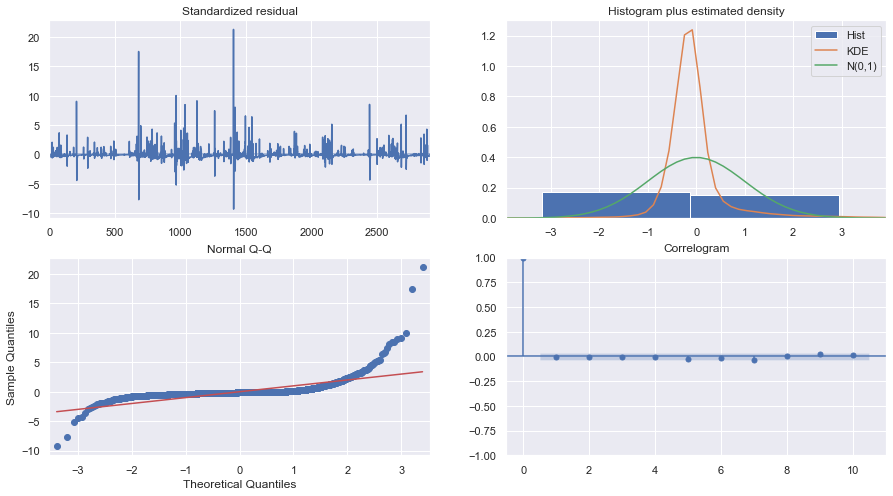

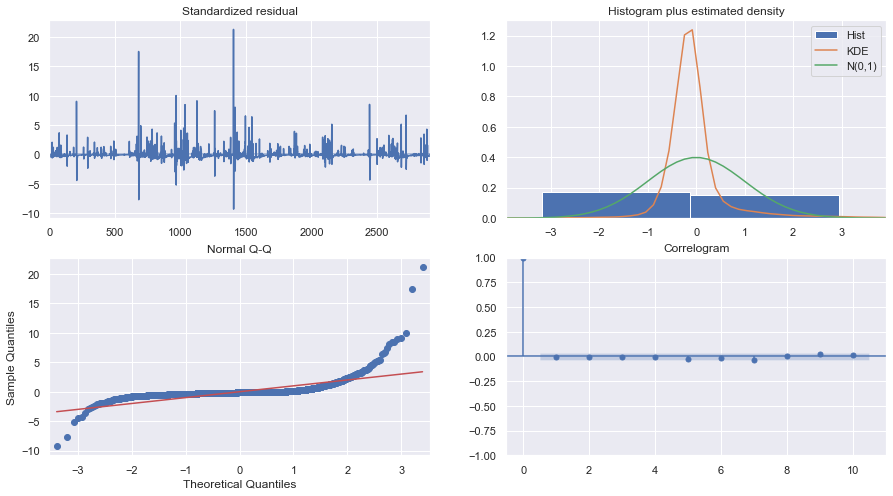

In [202]:
auto.plot_diagnostics()

In [203]:
params = auto.get_params()['order']
params

(5, 1, 1)

In [204]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create a SARIMAX model from statsmodel library
model = ARIMA(sample_train, order=auto.get_params()['order'])

In [205]:
# Fit the model
results = model.fit()

Check if we obtains the same model of the auto_arima:

In [206]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              discharge   No. Observations:                 2905
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -16716.709
Date:                Tue, 05 Jul 2022   AIC                          33447.419
Time:                        16:24:36   BIC                          33489.236
Sample:                    01-01-2011   HQIC                         33462.485
                         - 12-14-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9129      0.008    110.449      0.000       0.897       0.929
ar.L2         -0.1031      0.012     -8.327      0.000      -0.127      -0.079
ar.L3          0.0183      0.020      0.904      0.3

### Model Validate

In [208]:
# Generate predictions on one_step forecasting (with no updating)
one_step_forecast = results.get_prediction(start=-365)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower discharge']
upper_limits = confidence_intervals.loc[:, 'upper discharge']


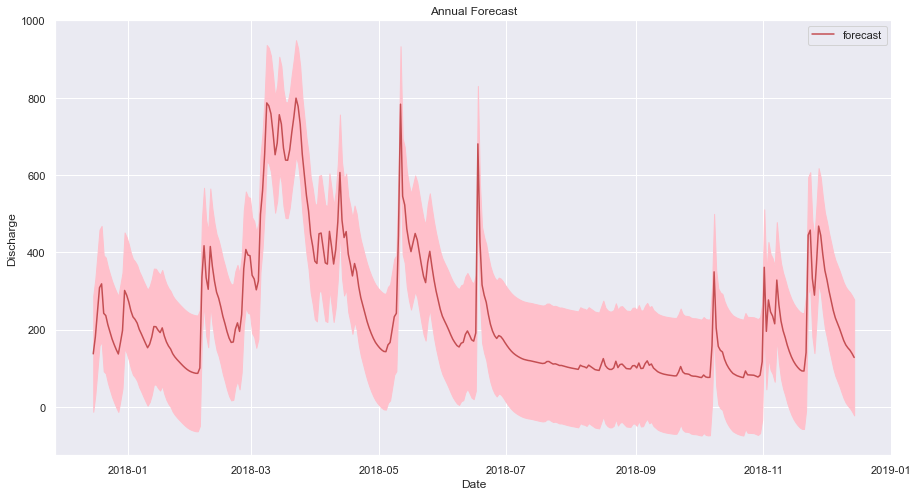

In [209]:
# plot the dranse data

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('Annual Forecast')
plt.legend()
plt.show()

Text(0.5, 0, 'Time')

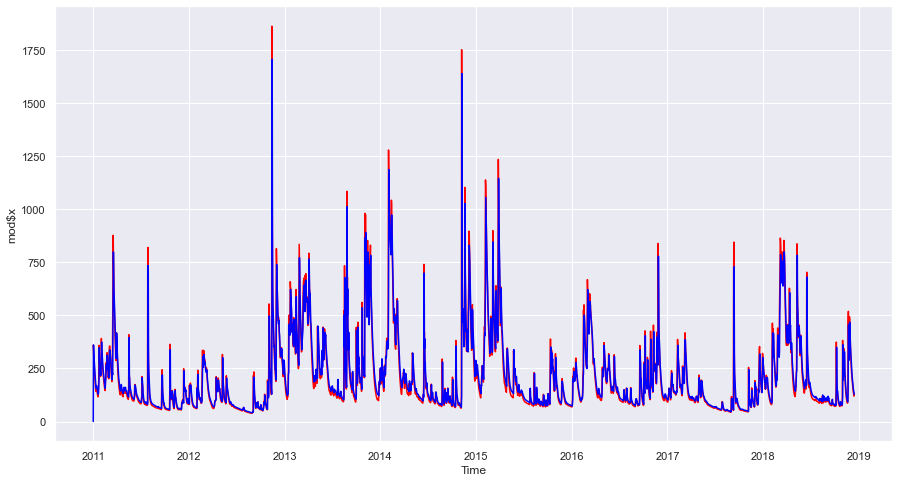

In [210]:
plt.plot(sample_train.discharge, c='red')
plt.plot(results.fittedvalues, c='blue')
plt.ylabel("mod$x")
plt.xlabel("Time")

### Model Evaluation

In [214]:
def forecast_to_df(model, steps=12):
    forecast = model.get_forecast(steps=steps, dynamic_forecast=True)
    pred_df = forecast.conf_int()
    pred_df['pred'] = forecast.predicted_mean
    pred_df.columns = ['lower', 'upper', 'pred']
    return pred_df

steps = len(sample_test)
pred_df = forecast_to_df(results, steps=len(sample_test))
pred_df.head()

,lower,upper,pred
2018-12-15 12:00:00,-9.908865,289.991474,140.041305
2018-12-16 12:00:00,-59.778947,350.659747,145.440400
2018-12-17 12:00:00,-86.192003,384.941190,149.374594
2018-12-18 12:00:00,-102.572936,407.014044,152.220554
2018-12-19 12:00:00,-113.096519,423.185180,155.044331


In [215]:
np.asarray(sample_test['discharge'])[1]

211.27441

(<Figure size 864x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Model Validation'}>)

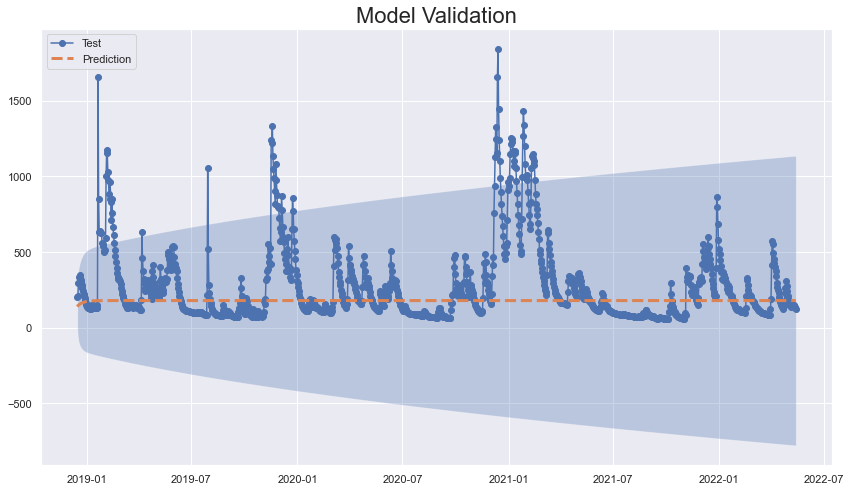

In [216]:
# Plotting Predictions
def plot_train_test_pred(test,pred_df):
    fig,ax = plt.subplots(figsize=(12,7))
    kws = dict(marker='o')
    
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['pred'],label='Prediction',ls='--',linewidth=3)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'],alpha=0.3)
    ax.set_title('Model Validation', fontsize=22)
    ax.legend(loc='upper left')
    fig.tight_layout()
    return fig,ax

plot_train_test_pred(sample_test,pred_df)



Given the high presence of the outliers and the high residual score, ARIMA results to be a bad model for long-term predictions.

In [219]:
import math

preds = pred_df.pred
trues = np.asarray(sample_test['discharge'])

rmse = math.sqrt(mean_squared_error(trues, preds))
mae = mean_absolute_error(trues, preds)
# the difference between 25th and 75th percentile,
diff_percentile = abs(np.percentile(trues, 25) - np.percentile(trues, 75))

nrmse = rmse / diff_percentile
nmae = mae / diff_percentile
print('Test NRMSE: {}'.format(nrmse))
print('Test NMAE: {}'.format(nmae))

Test NRMSE: 1.254830248477711
Test NMAE: 0.7440039113297495


In [269]:
# Source propagation
for key in arima_train.keys():
    print('Source of {}:'.format(key))
    sample_test = arima_test[key]['source']
    sample_train = arima_train[key]['source']
    auto = auto_arima(sample_train, start_p=0, start_q=0) # auto fit, we use it for auto best order and seasonal_order
    model = ARIMA(sample_train, order=auto.get_params()['order'])
    results = model.fit()
    steps = len(sample_test)
    pred_df = forecast_to_df(results, steps=len(sample_test))
    # plot_train_test_pred(sample_test, pred_df)
    preds = pred_df.pred
    trues = np.asarray(sample_test['discharge'])

    rmse = math.sqrt(mean_squared_error(trues, preds))
    mae = mean_absolute_error(trues, preds)
    # the difference between 25th and 75th percentile,
    diff_percentile = abs(np.percentile(trues, 25) - np.percentile(trues, 75))

    nrmse = rmse / diff_percentile
    nmae = mae / diff_percentile
    print('Test NRMSE: {}'.format(nrmse))
    print('Test NMAE: {}'.format(nmae))


Source of Tanaro:
Test NRMSE: 1.6031156065282792
Test NMAE: 0.8907102821354332
Source of Po:
Test NRMSE: 2.311471342727504
Test NMAE: 2.0595152960945695
Source of Tevere :
Test NRMSE: 1.4064839191685758
Test NMAE: 0.8000255035872921
Source of Arno:
Test NRMSE: 12.030634077485418
Test NMAE: 4.836039590337903
Source of Reno:
Test NRMSE: 2.862612420545676
Test NMAE: 1.1040014402855591
Source of Ticino:
Test NRMSE: 0.8679557212252369
Test NMAE: 0.6165018050305675
Source of Adda:
Test NRMSE: 2.1593407536422897
Test NMAE: 0.9419778378621151
Source of Oglio:
Test NRMSE: 1.434005534332407
Test NMAE: 0.7634880815015986
Source of Adige:
Test NRMSE: 1.2663699692494015
Test NMAE: 0.7971764878054561
Source of Piave:
Test NRMSE: 0.8836394803891411
Test NMAE: 0.6429518722248962


In [270]:
# Mouth propagation
for key in arima_train.keys():
    sample_test = arima_test[key]['mounth']
    sample_train = arima_train[key]['mounth']
    auto = auto_arima(sample_train, start_p=0, start_q=0) # auto fit, we use it for auto best order and seasonal_order
    model = ARIMA(sample_train, order=auto.get_params()['order'])
    results = model.fit()
    steps = len(sample_test)
    pred_df = forecast_to_df(results, steps=len(sample_test))
    # plot_train_test_pred(sample_test, pred_df)
    preds = pred_df.pred
    trues = np.asarray(sample_test['discharge'])

    rmse = math.sqrt(mean_squared_error(trues, preds))
    mae = mean_absolute_error(trues, preds)
    # the difference between 25th and 75th percentile,
    diff_percentile = abs(np.percentile(trues, 25) - np.percentile(trues, 75))

    nrmse = rmse / diff_percentile
    nmae = mae / diff_percentile
    print('Mouth of {}:'.format(key))
    print('Test NRMSE: {}'.format(nrmse))
    print('Test NMAE: {}'.format(nmae))

Mouth of Tanaro:
Test NRMSE: 2.827839578803754
Test NMAE: 2.077678133365107
Mouth of Po:
Test NRMSE: 0.9900770059271299
Test NMAE: 0.7812168742817944
Mouth of Tevere :
Test NRMSE: 1.254830248477711
Test NMAE: 0.7440039113297495
Mouth of Arno:
Test NRMSE: 2.016761642215786
Test NMAE: 1.0525040420110838
Mouth of Reno:
Test NRMSE: 3.9713383220440797
Test NMAE: 2.6002786789678805
Mouth of Ticino:
Test NRMSE: 0.8106214883262001
Test NMAE: 0.5908133201809338
Mouth of Adda:
Test NRMSE: 1.4177879183818296
Test NMAE: 0.8396142716191113
Mouth of Oglio:
Test NRMSE: 0.9617096857039972
Test NMAE: 0.8046173328747608
Mouth of Adige:
Test NRMSE: 0.8727679852142096
Test NMAE: 0.600568196193612
Mouth of Piave:
Test NRMSE: 1.0015349635843442
Test NMAE: 0.6569724059418861


Generally, forecasting techniques have some problems for long-term predictions. We can see from the previous plot how the MSE varies over time, and the impact of instant discharge variations is not caught. This aspect is influenced by the randomness distribution given by the analysis of discharges during the ACF and PACF analysis. So, we can estimate that ARIMA usage is not a good approach for our final application.

## ANN and LSTM

### Splitting Test and Train for LSTM

In [162]:
sample_train  = train['Tevere ']['mounth']
sample_test = test['Tevere ']['mounth']

# clean and format training data 
sample_train.discharge = sample_train.discharge.astype(float)
sample_train.prec = sample_train.prec.astype(float)
sample_train.temp = sample_train.temp.astype(float)
sample_train = sample_train.drop(columns=['time'])

# clean and format testing data
sample_test.discharge = sample_test.discharge.astype(float)
sample_test.prec = sample_test.prec.astype(float)
sample_test.temp = sample_test.temp.astype(float)
sample_test = sample_test.drop(columns=['time'])
sample_train.tail()

,discharge,temp,prec
2521398,145.627930,8.610651,2.309112e-10
2521399,139.353520,9.400873,2.650724e-12
2521400,130.665040,8.396082,9.117005e-13
2521401,119.768555,7.348291,3.611122e-14
2521402,132.175780,7.709558,9.245022e-15


In [16]:
sample_train.head()

,discharge,temp,prec
2521055,360.40430,13.433801,8.373320e-06
2521056,326.18262,13.917352,7.232591e-05
2521057,298.91602,12.954095,1.324906e-05
2521058,273.66602,14.221063,1.107795e-07
2521059,248.28418,12.358911,3.284007e-05


In [170]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [171]:
np.random.seed(7)

In [172]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(sample_train)
scaled_test = scaler.fit_transform(sample_test)

In [173]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [174]:
# frame as supervised learning
reframed_train = series_to_supervised(scaled_train, 1, 1)
reframed_test = series_to_supervised(scaled_test, 1, 1)

In [175]:
reframed_train.drop(reframed_train.columns[[4, 5]], axis=1, inplace=True)
reframed_test.drop(reframed_test.columns[[4, 5]], axis=1, inplace=True)

In [176]:
print(reframed_train.head(), '\n---------------------------------------------\n', reframed_test.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.176575   0.445207   0.007006  0.157803
2   0.157803   0.460727   0.060515  0.142847
3   0.142847   0.429809   0.011085  0.128996
4   0.128996   0.470476   0.000093  0.115073
5   0.115073   0.410705   0.027477  0.104182 
---------------------------------------------
    var1(t-1)  var2(t-1)     var3(t-1)   var1(t)
1   0.082825   0.275831  4.739330e-07  0.086732
2   0.086732   0.274031  7.989973e-07  0.132328
3   0.132328   0.228227  7.475525e-04  0.154564
4   0.154564   0.379012  4.021070e-03  0.162929
5   0.162929   0.421302  3.207199e-03  0.153549


In [177]:
values_train = reframed_train.values
values_test = reframed_test.values
# split into input and outputs
train_X, train_y = values_train[:, :-1], values_train[:, -1]
test_X, test_y = values_test[:, :-1], values_test[:, -1]

In [178]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2904, 1, 3) (2904,) (1245, 1, 3) (1245,)


2022-07-05 16:03:46.402233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
41/41 - 2s - loss: 0.0691 - val_loss: 0.0695 - 2s/epoch - 48ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0465 - val_loss: 0.0420 - 89ms/epoch - 2ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0350 - val_loss: 0.0284 - 90ms/epoch - 2ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0248 - val_loss: 0.0229 - 86ms/epoch - 2ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0224 - val_loss: 0.0178 - 99ms/epoch - 2ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0205 - val_loss: 0.0193 - 89ms/epoch - 2ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0208 - val_loss: 0.0184 - 87ms/epoch - 2ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0191 - val_loss: 0.0188 - 88ms/epoch - 2ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0208 - val_loss: 0.0186 - 92ms/epoch - 2ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0184 - val_loss: 0.0167 - 107ms/epoch - 3ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0183 - val_loss: 0.0197 - 91ms/epoch - 2ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0199 - val_loss: 0.0173 - 108ms/epoch - 3ms/step
Epoch 13/50
41/41 - 0s - loss: 0.019

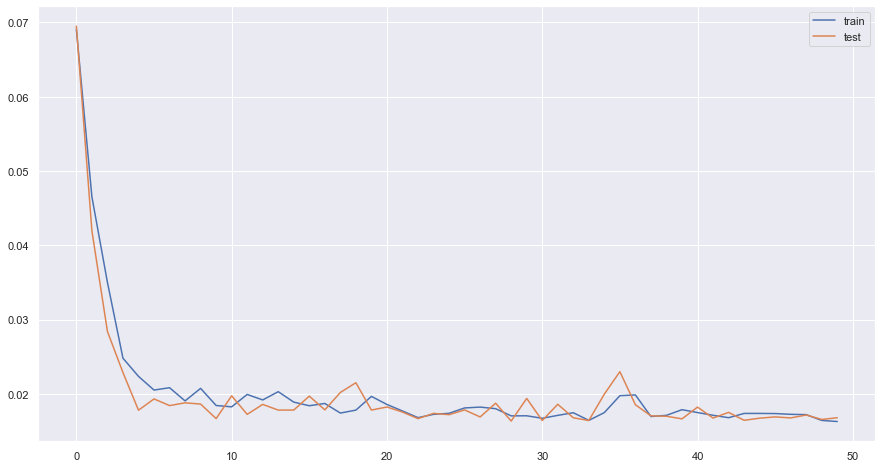

In [179]:
# design network
model = Sequential()
model.add(LSTM(27, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(108))
model.add(Dropout(0.5))
model.add(Dense(12))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [182]:
import math
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
diff_percentile = abs(np.percentile(inv_y, 25) - np.percentile(inv_y, 75))
nrmse = rmse / diff_percentile
nmae = mae / diff_percentile

print('Test NRMSE: {}'.format(nrmse))
print('Test NMAE: {}'.format(nmae))


39/39 [==============================] - 1s 2ms/step
Test NRMSE: 0.37888857294263883
Test NMAE: 0.1346226922225778


### Monthly prediction modelling

In [2]:
import pandas as pd # it is used for the time series management dataset.
import numpy as np # it is used to manage collections of values in the pandas dataframe.
import json 
import datetime as dt
import warnings
import math
import matplotlib.pyplot as plt
import pickle
from keras.models import load_model

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras import metrics
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
from keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='root_mean_squared_error', patience=30, mode='min')

In [5]:
#Load dataset
df = pd.read_pickle('../../monthly/grouped_all.pkl')

In [6]:
# filter points from original dataset to geojson coordinates related to river positions.
coords = json.load(open('../app/static/data/points_new_fill.geojson', 'r'))
lats = []
longs = []
for coord in coords['features'][:]:
    sample = coord['geometry']['coordinates']
    lats.append(sample[1])
    longs.append(sample[0])


In [7]:
datasource = json.load(open('../samples/source_mounth.json', 'r'))
sources_rivers = []
names = []
mounths_rivers = []
italy_sources_mounths = pd.DataFrame()
for key in datasource.keys():
    sources_rivers.append(datasource[key]['source'])
    mounths_rivers.append(datasource[key]['mounth'])
    names.append(key)

italy_sources_mounths['names'] = names
italy_sources_mounths['mounth'] = mounths_rivers
italy_sources_mounths['source'] = sources_rivers
italy_sources_mounths['number_value'] = [i for i in range(0, len(italy_sources_mounths))]
italy_sources_mounths.head()

,names,mounth,source,number_value
0,Tanaro,"[44.950962, 8.690675]","[44.12503, 7.8367176]",0
1,Po,"[44.974716, 12.487255]","[44.841927, 7.6197023]",1
2,Tevere,"[41.730213, 12.233403]","[42.679653, 12.207837]",2
3,Arno,"[43.69623, 10.266045]","[43.864105, 11.632074]",3
4,Reno,"[44.61863, 12.282794]","[44.410408, 11.271765]",4


In [8]:
#dictionaries with the dataframe for each river
sources = {}
mounths = {}
names = list(italy_sources_mounths.names)
for i in range(len(italy_sources_mounths)):
    name = names[i]
    sources[name] = df[df['coords'] == tuple(italy_sources_mounths['source'][i])]
    mounths[name] = df[df['coords'] == tuple(italy_sources_mounths['mounth'][i])]

In [9]:
for name in sources:
    sources[name] = sources[name].set_index('time')
    mounths[name] = mounths[name].set_index('time')

In [10]:
#conversion from a single column dataframe to two arrays, one with the observations and one with the label to predict
def df_to_supervised_discharge(df, window_size=12):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [11]:
#conversion from a single column dataframe to two arrays, one with the observations and one with the label to predict
def df_to_supervised_temperature(df, window_size=12):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [12]:
#add column with seconds to do the sin cos trick
for name in sources:
    sources[name]['secs'] = sources[name].index.map(pd.Timestamp.timestamp)
    mounths[name]['secs'] = mounths[name].index.map(pd.Timestamp.timestamp)

In [13]:

day = 60*60*24
year = 365.2425*day
for name in sources:
    sources[name]['year_sin'] = np.sin(sources[name]['secs']*(2*np.pi/year))
    mounths[name]['year_sin'] = np.sin(mounths[name]['secs']*(2*np.pi/year))

    sources[name]['year_cos'] = np.cos(sources[name]['secs']*(2*np.pi/year))
    mounths[name]['year_cos'] = np.cos(mounths[name]['secs']*(2*np.pi/year))

    sources[name] = sources[name].drop(columns=['secs'])
    mounths[name] = mounths[name].drop(columns=['secs'])

In [13]:
sources['Tevere '].drop(columns=['prec', 'discharge'])

,coords,temp,year_sin,year_cos
time,,,,
2011-01-15,"(42.679653, 12.207837)",8.797117,0.239478,0.970902
2011-02-15,"(42.679653, 12.207837)",5.777048,0.699798,0.714341
2011-03-15,"(42.679653, 12.207837)",6.310610,0.951104,0.308870
2011-04-15,"(42.679653, 12.207837)",12.820533,0.976054,-0.217529
2011-05-15,"(42.679653, 12.207837)",15.912722,0.741586,-0.670858
...,...,...,...,...
2022-01-15,"(42.679653, 12.207837)",9.267187,0.245027,0.969516
2022-02-15,"(42.679653, 12.207837)",10.023776,0.703872,0.710327
2022-03-15,"(42.679653, 12.207837)",10.524881,0.952855,0.303424


1/1 [==============================] - 0s 365ms/step
Test on sources for Tanaro
Test NRMSE: 0.197
Test NMAE: 0.167


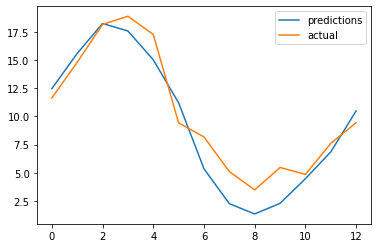

1/1 [==============================] - 0s 386ms/step
Test on sources for Po
Test NRMSE: 0.203
Test NMAE: 0.152


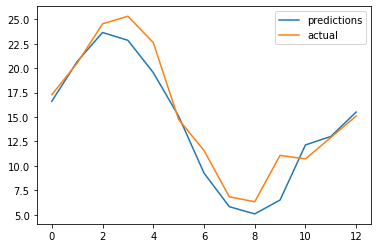

1/1 [==============================] - 1s 761ms/step
Test on sources for Tevere 
Test NRMSE: 0.141
Test NMAE: 0.119


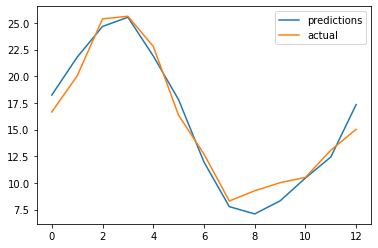

1/1 [==============================] - 0s 439ms/step
Test on sources for Arno
Test NRMSE: 0.207
Test NMAE: 0.180


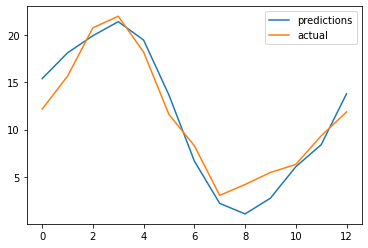

1/1 [==============================] - 0s 384ms/step
Test on sources for Reno
Test NRMSE: 0.180
Test NMAE: 0.154


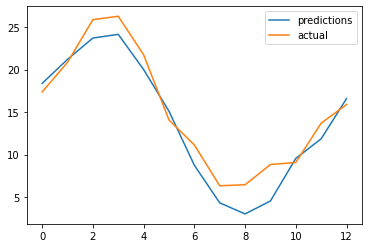

1/1 [==============================] - 0s 410ms/step
Test on sources for Ticino
Test NRMSE: 0.116
Test NMAE: 0.097


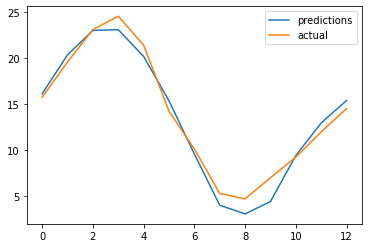

1/1 [==============================] - 0s 403ms/step
Test on sources for Adda
Test NRMSE: 0.194
Test NMAE: 0.182


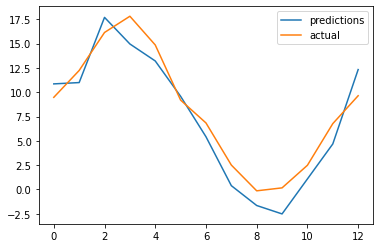

1/1 [==============================] - 0s 368ms/step
Test on sources for Oglio
Test NRMSE: 0.241
Test NMAE: 0.200


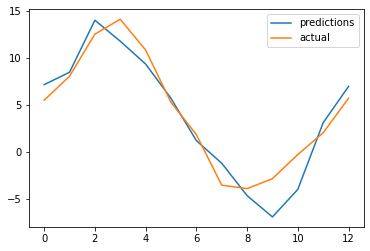

1/1 [==============================] - 0s 388ms/step
Test on sources for Adige
Test NRMSE: 0.357
Test NMAE: 0.310


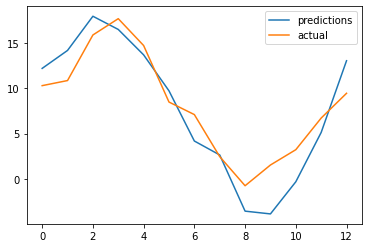

1/1 [==============================] - 0s 381ms/step
Test on sources for Piave
Test NRMSE: 0.324
Test NMAE: 0.293


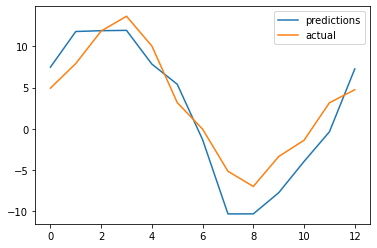

In [15]:
for name in sources:
    src = sources[name].drop(columns=['prec', 'discharge', 'coords'])
    #creating the x tensor and the labels
    X, y = df_to_supervised_temperature(src)

    #splitting
    n = len(X)
    X_train, y_train = X[0:int(n*0.7)], y[0:int(n*0.7)]
    X_val, y_val = X[int(n*0.7):int(n*0.9)], y[int(n*0.7):int(n*0.9)]
    X_test, y_test = X[int(n*0.9):], y[int(n*0.9):]

    model_tmp_src = Sequential()
    model_tmp_src.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_tmp_src.add(Dense(12))
    model_tmp_src.add(Dense(1))

    #model2.summary()
    model_tmp_src.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])
    model_tmp_src.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, verbose=0, callbacks=[stop])

    test_predictions = model_tmp_src.predict(X_test).flatten()
    test_results = pd.DataFrame(data={'Preds': test_predictions, 'Actuals':y_test})
    rmse = math.sqrt(mean_squared_error(test_predictions, y_test))
    mae = mean_absolute_error(test_predictions, y_test)
    diff_percentile = abs(np.percentile(y_test, 25) - np.percentile(y_test, 75))

    nrmse = rmse / diff_percentile
    nmae = mae / diff_percentile

    print('Test on sources for '+ name)
    print('Test NRMSE: %.3f' % nrmse)
    print('Test NMAE: %.3f' % nmae)
    plt.plot(test_predictions, label='predictions')
    plt.plot(y_test, label='actual')
    plt.legend(loc="upper right")
    plt.show()

1/1 [==============================] - 0s 384ms/step
Test on mouths for Tanaro
Test NRMSE: 0.16484203203899603
Test NMAE: 0.14287072659620015


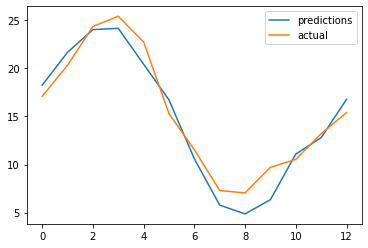

1/1 [==============================] - 0s 375ms/step
Test on mouths for Po
Test NRMSE: 0.16632195986605589
Test NMAE: 0.13615602759335976


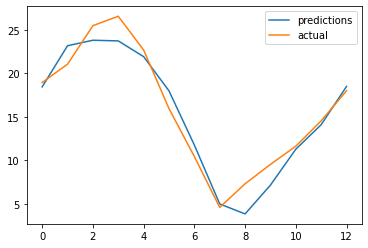

1/1 [==============================] - 0s 381ms/step
Test on mouths for Tevere 
Test NRMSE: 0.13447605731510495
Test NMAE: 0.11367419592222854


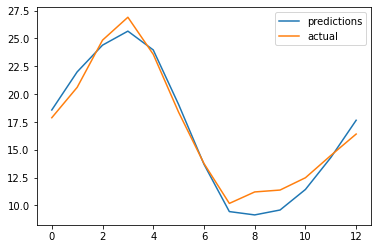

1/1 [==============================] - 0s 371ms/step
Test on mouths for Arno
Test NRMSE: 0.19126101183314576
Test NMAE: 0.14640820810440652


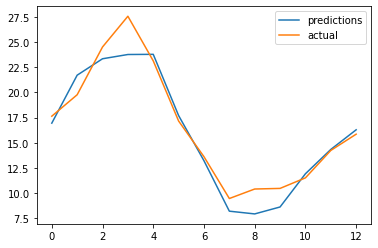

1/1 [==============================] - 0s 380ms/step
Test on mouths for Reno
Test NRMSE: 0.2046874368876201
Test NMAE: 0.16152308520918413


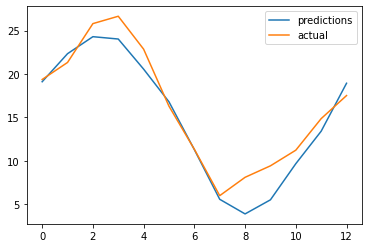

1/1 [==============================] - 0s 373ms/step
Test on mouths for Ticino
Test NRMSE: 0.12993081230591588
Test NMAE: 0.11250023585517646


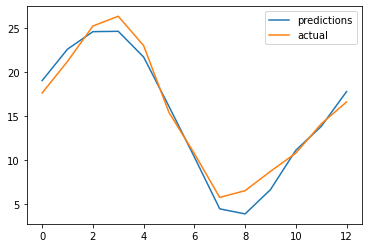

1/1 [==============================] - 0s 369ms/step
Test on mouths for Adda
Test NRMSE: 0.17951137601083617
Test NMAE: 0.14060060875678096


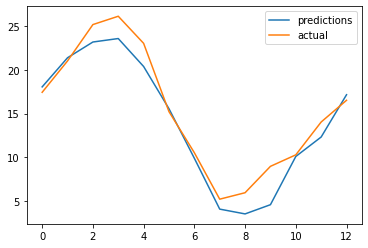

1/1 [==============================] - 0s 373ms/step
Test on mouths for Oglio
Test NRMSE: 0.17522790932434376
Test NMAE: 0.13985869082652075


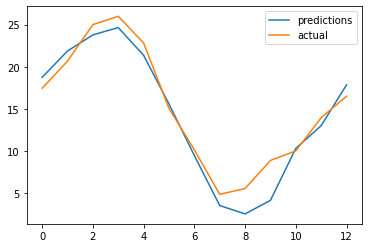

1/1 [==============================] - 0s 367ms/step
Test on mouths for Adige
Test NRMSE: 0.18464386912678157
Test NMAE: 0.15059674849888824


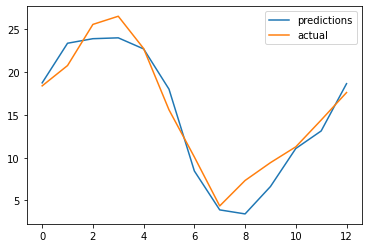

1/1 [==============================] - 0s 395ms/step
Test on mouths for Piave
Test NRMSE: 0.18490185600065406
Test NMAE: 0.15129779435510893


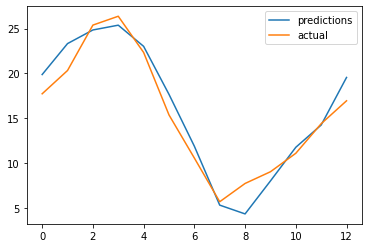

In [16]:
for name in sources:
    src = mounths[name].drop(columns=['prec', 'discharge', 'coords'])
    #creating the x tensor and the labels
    X, y = df_to_supervised_temperature(src)

    #splitting
    n = len(X)
    X_train, y_train = X[0:int(n*0.7)], y[0:int(n*0.7)]
    X_val, y_val = X[int(n*0.7):int(n*0.9)], y[int(n*0.7):int(n*0.9)]
    X_test, y_test = X[int(n*0.9):], y[int(n*0.9):]

    model_tmp_mth = Sequential()
    model_tmp_mth.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_tmp_mth.add(Dense(12))
    model_tmp_mth.add(Dense(1))

    #model2.summary()
    model_tmp_mth.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])
    model_tmp_mth.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, verbose=0)
    test_predictions = model_tmp_mth.predict(X_test).flatten()
    test_results = pd.DataFrame(data={'Preds': test_predictions, 'Actuals':y_test})
    rmse = math.sqrt(mean_squared_error(test_predictions, y_test))
    mae = mean_absolute_error(test_predictions, y_test)
    print('Test on mouths for '+name)
    diff_percentile = abs(np.percentile(y_test, 25) - np.percentile(y_test, 75))
    nrmse = rmse / diff_percentile
    nmae = mae / diff_percentile
    print('Test NRMSE: {}'.format(nrmse))
    print('Test NMAE: {}'.format(nmae))
    plt.plot(test_predictions, label='predictions')
    plt.plot(y_test, label='actual')
    plt.legend(loc="upper right")
    plt.show()

1/1 [==============================] - 0s 373ms/step
Test on sources for Tanaro
Test NRMSE: 1.7347832936475454
Test NMAE: 1.4309036050028645


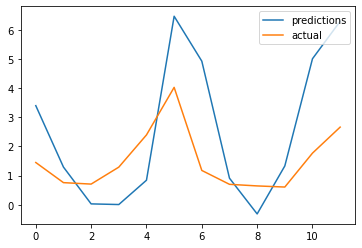

1/1 [==============================] - 0s 403ms/step
Test on sources for Po
Test NRMSE: 2.6211877191567314
Test NMAE: 2.2469870940042074


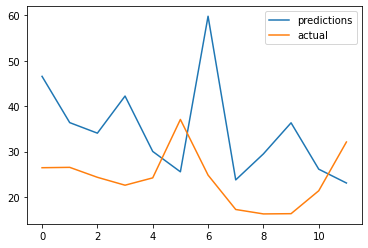

1/1 [==============================] - 0s 377ms/step
Test on sources for Tevere 
Test NRMSE: 1.1634881141715094
Test NMAE: 0.8836126409776421


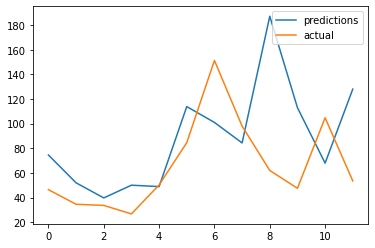

1/1 [==============================] - 0s 369ms/step
Test on sources for Arno
Test NRMSE: 45.35378263026459
Test NMAE: 44.83286369921326


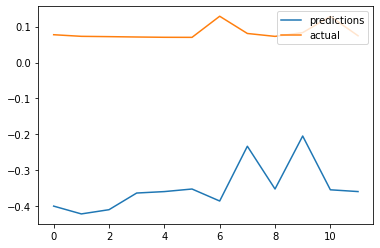

1/1 [==============================] - 0s 366ms/step
Test on sources for Reno
Test NRMSE: 0.5685303882986131
Test NMAE: 0.4424052765248815


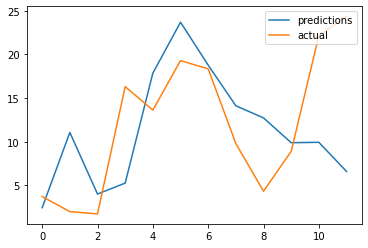

1/1 [==============================] - 0s 384ms/step
Test on sources for Ticino
Test NRMSE: 0.6546660339938292
Test NMAE: 0.4847043623593883


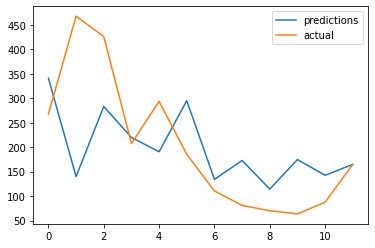

1/1 [==============================] - 0s 366ms/step
Test on sources for Adda
Test NRMSE: 1.7987822241248632
Test NMAE: 1.3025599254279216


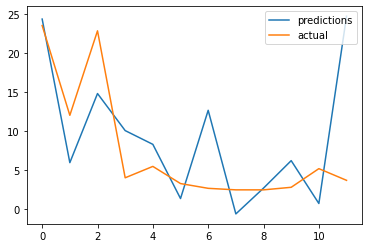

1/1 [==============================] - 0s 371ms/step
Test on sources for Oglio
Test NRMSE: 0.4682184790724083
Test NMAE: 0.3348805502501167


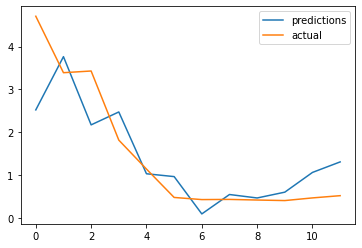

1/1 [==============================] - 0s 367ms/step
Test on sources for Adige
Test NRMSE: 0.7630383285866733
Test NMAE: 0.4826990820250451


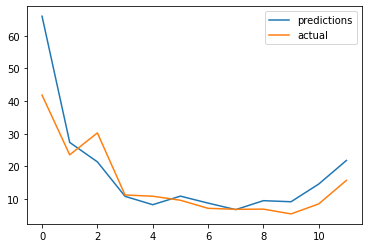

1/1 [==============================] - 0s 373ms/step
Test on sources for Piave
Test NRMSE: 1.2865399222119622
Test NMAE: 0.9400754419221591


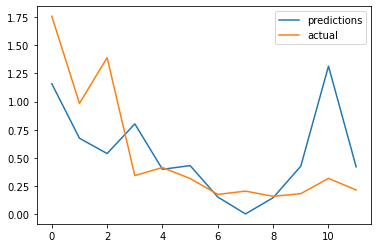

In [22]:
for name in sources:
    src = sources[name].drop(columns=['prec', 'coords'])
    #creating the x tensor and the labels
    X, y = df_to_supervised_discharge(src, 24)

    #splitting
    n = len(X)
    X_train, y_train = X[0:int(n*0.7)], y[0:int(n*0.7)]
    X_val, y_val = X[int(n*0.7):int(n*0.9)], y[int(n*0.7):int(n*0.9)]
    X_test, y_test = X[int(n*0.9):], y[int(n*0.9):]
    #normalizing
    X_mean = X_train.mean()
    X_std = X_train.std()
    X_train_sc = (X_train - X_mean) / X_std
    X_val_sc = (X_val - X_mean) / X_std
    X_test_sc = (X_test - X_mean) / X_std


    y_mean = y_train.mean()
    y_std = y_train.std()
    y_train_sc = (y_train - X_mean) / X_std
    y_val_sc = (y_val - X_mean) / X_std
    y_test_sc = (y_test - X_mean) / X_std
    
    model_dis_src = Sequential()
    model_dis_src.add(LSTM(32, input_shape=(X_train_sc.shape[1], X_train_sc.shape[2])))
    model_dis_src.add(Dense(12))
    model_dis_src.add(Dense(1))

    #model2.summary()
    model_dis_src.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])
    model_dis_src.fit(X_train_sc, y_train_sc, validation_data=(X_val_sc, y_val_sc), epochs=40000, verbose=0, callbacks=[stop])

    test_predictions = model_dis_src.predict(X_test_sc).flatten()
    test_predictions = (test_predictions*X_std)+X_mean
    rmse = math.sqrt(mean_squared_error(test_predictions, y_test))
    mae = mean_absolute_error(test_predictions, y_test)
    print('Test on sources for '+name)
    diff_percentile = abs(np.percentile(y_test, 25) - np.percentile(y_test, 75))
    nrmse = rmse / diff_percentile
    nmae = mae / diff_percentile
    print('Test NRMSE: {}'.format(nrmse))
    print('Test NMAE: {}'.format(nmae))
    plt.plot(test_predictions, label='predictions')
    plt.plot(y_test, label='actual')
    plt.legend(loc="upper right")
    plt.show()

1/1 [==============================] - 0s 372ms/step
Test on mouths for Tanaro
Test NRMSE: 1.8606238946011635
Test NMAE: 1.6218298381662255


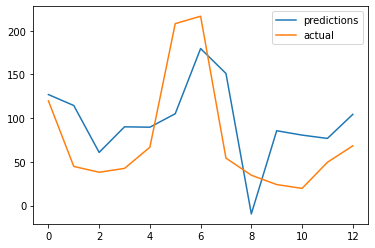

1/1 [==============================] - 0s 392ms/step
Test on mouths for Po
Test NRMSE: 0.9121664868306295
Test NMAE: 0.7193517776607943


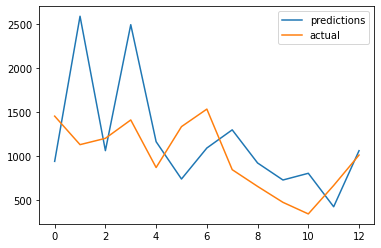

1/1 [==============================] - 0s 377ms/step
Test on mouths for Tevere 
Test NRMSE: 0.9965917600283821
Test NMAE: 0.7316847687377281


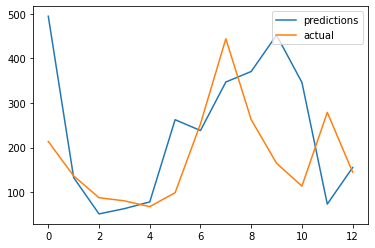

1/1 [==============================] - 0s 370ms/step
Test on mouths for Arno
Test NRMSE: 0.9187374038143336
Test NMAE: 0.7741690427222262


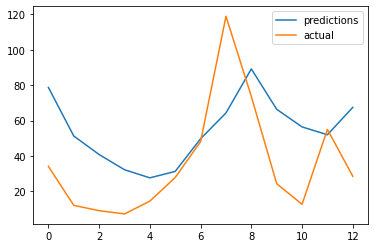

1/1 [==============================] - 0s 368ms/step
Test on mouths for Reno
Test NRMSE: 1.8687188991542951
Test NMAE: 1.6089620327452983


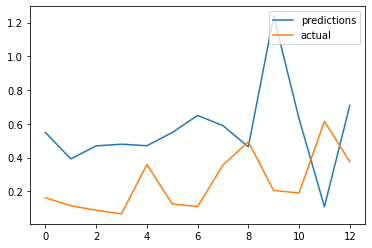

KeyboardInterrupt: 

In [21]:
for name in mounths:
    src = mounths[name].drop(columns=['prec', 'coords'])
    #creating the x tensor and the labels
    X, y = df_to_supervised_discharge(src)

    #splitting
    n = len(X)
    X_train, y_train = X[0:int(n*0.7)], y[0:int(n*0.7)]
    X_val, y_val = X[int(n*0.7):int(n*0.9)], y[int(n*0.7):int(n*0.9)]
    X_test, y_test = X[int(n*0.9):], y[int(n*0.9):]
    #normalizing
    X_mean = X_train.mean()
    X_std = X_train.std()
    X_train_sc = (X_train - X_mean) / X_std
    X_val_sc = (X_val - X_mean) / X_std
    X_test_sc = (X_test - X_mean) / X_std


    y_mean = y_train.mean()
    y_std = y_train.std()
    y_train_sc = (y_train - X_mean) / X_std
    y_val_sc = (y_val - X_mean) / X_std
    y_test_sc = (y_test - X_mean) / X_std
    
    model_dis_mth = Sequential()
    model_dis_mth.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_dis_mth.add(Dense(12))
    model_dis_mth.add(Dense(1))

    #model2.summary()
    model_dis_mth.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])
    model_dis_mth.fit(X_train_sc, y_train_sc, validation_data=(X_val_sc, y_val_sc), epochs=40000, verbose=0, callbacks=[stop])

    test_predictions = model_dis_mth.predict(X_test_sc).flatten()
    test_predictions = (test_predictions*X_std)+X_mean
    rmse = math.sqrt(mean_squared_error(test_predictions, y_test))
    mae = mean_absolute_error(test_predictions, y_test)
    print('Test on mouths for '+name)
    diff_percentile = abs(np.percentile(y_test, 25) - np.percentile(y_test, 75))
    nrmse = rmse / diff_percentile
    nmae = mae / diff_percentile

    print('Test NRMSE: {}'.format(nrmse))
    print('Test NMAE: {}'.format(nmae))
    plt.plot(test_predictions, label='predictions')
    plt.plot(y_test, label='actual')
    plt.legend(loc="upper right")
    plt.show()